In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, PDB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, \
    PKL_PATH, get_structures

from sklearn.metrics import mean_squared_error as calc_rmse


0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

<Figure size 100x100 with 0 Axes>

# Mike's data

In [2]:
EPOL = pd.read_csv("mikedata/epol.dat", sep=" ", header=None)
EPOL["KEY"] = EPOL[0].apply(lambda x: f"test{x}")
EPOL.index = EPOL.KEY
EPOL["EPOL"] = EPOL[1]
EPOL

,0,1,KEY,EPOL
KEY,,,,
test0,0,-12.842979,test0,-12.842979
test1,1,-12.893629,test1,-12.893629
test2,2,-10.587563,test2,-10.587563
test3,3,-9.974705,test3,-9.974705
test4,4,-19.145629,test4,-19.145629
...,...,...,...,...
test495,495,-12.622225,test495,-12.622225
test496,496,-11.377266,test496,-11.377266
test497,497,-12.797393,test497,-12.797393


In [3]:
EEL = pd.read_csv("mikedata/eel.dat", sep=" ", header=None)
EEL["KEY"] = EEL[0] #.apply(lambda x: f"test{x}")
EEL.index = EEL.KEY
EEL["EEL"] = EEL[1]
EEL

,0,1,KEY,EEL
KEY,,,,
test0,test0,-169.440137,test0,-169.440137
test1,test1,-196.231248,test1,-196.231248
test2,test2,-166.139671,test2,-166.139671
test3,test3,-161.368805,test3,-161.368805
test4,test4,-232.955971,test4,-232.955971
...,...,...,...,...
test495,test495,-196.800926,test495,-196.800926
test496,test496,-183.468859,test496,-183.468859
test497,test497,-198.441423,test497,-198.441423


In [4]:
data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_redo_pbe0dz_pc.pkl")

In [5]:
data_ = data.data
data_.index = data_.KEY

In [6]:
data_ = data_.join(EPOL[["EPOL"]])
data_ = data_.join(EEL[["EEL"]])
data_["ELECcipol"] = data_["EEL"] + data_["EPOL"]

In [7]:
data_

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,EPOL,EEL,ELECcipol
KEY,,,,,,,,,,,,
test467,10.30112,-82.11234,27.55810,test467,-1527.187866,20,-1527.328541,-88.274060,-958403.241564,-13.997233,-204.285470,-218.282702
test263,11.34510,-93.28769,29.22768,test263,-1527.183081,20,-1527.326127,-89.762384,-958401.726960,-16.226241,-200.292616,-216.518857
test35,11.00067,-77.72898,32.02998,test35,-1527.185703,20,-1527.300030,-71.740517,-958385.350512,-14.940271,-201.529407,-216.469677
test223,10.80442,-71.94916,29.97665,test223,-1527.186209,20,-1527.289994,-65.125035,-958379.052942,-11.214738,-196.196009,-207.410747
test254,10.92780,-79.63452,16.86211,test254,-1527.186066,20,-1527.331554,-91.293912,-958405.132180,-11.906108,-165.989306,-177.895414
...,...,...,...,...,...,...,...,...,...,...,...,...
test100,12.22319,-77.94768,22.40034,test100,-1527.183347,20,-1527.307506,-77.910277,-958390.041931,-13.341739,-176.613840,-189.955580
test304,10.84565,-93.69849,32.56187,test304,-1527.190149,20,-1527.335938,-91.482928,-958407.882889,-16.469006,-221.501781,-237.970788
test327,11.03942,-60.99375,19.52537,test327,-1527.185234,20,-1527.278286,-58.390447,-958371.706595,-8.590109,-156.347588,-164.937697


In [8]:
structure = "water_redo"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 500 500


In [9]:
data_.sort_values("intE")

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,EPOL,EEL,ELECcipol
KEY,,,,,,,,,,,,
test76,11.33225,-67.56906,11.86175,test76,-1450.824462,19,-1527.317213,-47999.431132,-958396.133272,-11.009809,-143.598684,-154.608492
test4,10.27541,-109.19208,27.26727,test4,-1527.185213,20,-1527.382846,-124.015319,-958437.318158,-19.145629,-232.955971,-252.101601
test397,10.15704,-95.40840,18.62454,test397,-1527.183434,20,-1527.373442,-119.230703,-958431.417007,-17.109367,-206.541158,-223.650525
test67,9.67477,-102.99200,23.40678,test67,-1527.186353,20,-1527.375924,-118.956698,-958432.974463,-18.410357,-225.722919,-244.133276
test151,9.62300,-101.83325,25.87094,test151,-1527.186545,20,-1527.372006,-116.377171,-958430.516032,-15.917577,-221.982011,-237.899588
...,...,...,...,...,...,...,...,...,...,...,...,...
test365,12.55191,-63.82734,15.50390,test365,-1527.183359,20,-1527.276873,-58.680177,-958370.819613,-8.073924,-146.246458,-154.320382
test327,11.03942,-60.99375,19.52537,test327,-1527.185234,20,-1527.278286,-58.390447,-958371.706595,-8.590109,-156.347588,-164.937697
test177,11.16631,-54.76676,11.94163,test177,-1527.184798,20,-1527.275996,-57.226912,-958370.269331,-7.511043,-132.400228,-139.911271


In [10]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

array([[<AxesSubplot:title={'center':'TOTAL'}>,
        <AxesSubplot:title={'center':'ELEC'}>,
        <AxesSubplot:title={'center':'VDW'}>],
       [<AxesSubplot:title={'center':'M_ENERGY'}>,
        <AxesSubplot:title={'center':'n_monomers'}>,
        <AxesSubplot:title={'center':'C_ENERGY'}>],
       [<AxesSubplot:title={'center':'intE'}>,
        <AxesSubplot:title={'center':'C_ENERGY_kcalmol'}>,
        <AxesSubplot:title={'center':'EPOL'}>],
       [<AxesSubplot:title={'center':'EEL'}>,
        <AxesSubplot:title={'center':'ELECcipol'}>, <AxesSubplot:>]],
      dtype=object)

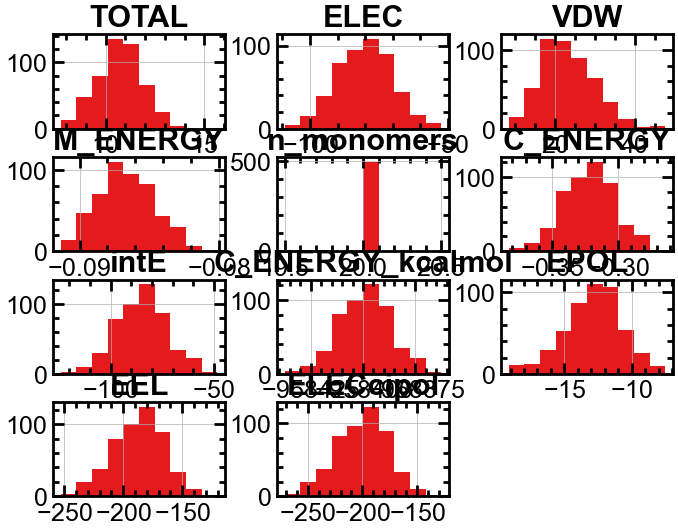

In [11]:
# dists.keys()
data_.sort_values("intE")[1:].hist()

In [12]:
ljpcff = FF(
    data_.sort_values("intE")[1:], # pd.DataFrame
    dists, #
    FUNC, #
    BOUNDS, # tuple
    struct_data, 
    elec="ELECcipol",
    intE=target,
)
#  set the targets
ljpcff.num_segments = len(ljpcff.data)
print("Nsegments", ljpcff.num_segments)
ljpcff.set_targets()

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
test0      -87.133554
test1      -76.513047
test10     -79.349417
test100    -77.910277
test101   -105.550755
              ...    
test95     -99.981490
test96     -83.650982
test97     -89.793709
test98     -85.995753
test99    -104.441875
Name: intE, Length: 499, dtype: float64
count    499.000000
mean     -84.993032
std       12.199610
min     -124.015319
25%      -93.673582
50%      -84.589632
75%      -76.703359
max      -48.367304
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [2.9488142711569245, 3.9463245487980037, 0.4092199618902533, 0.7578867485447096]
sig [5.897628542313849, 6.895138819954928, 7.892649097596007]
ep [0.4092199618902533, 0.5569042883266334, 0.7578867485447096]
epsilons {'HT': 0.4092199

In [13]:
ljpcff.bounds

[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]

In [14]:
ljpcff.targets

Array([ 95.14956 , 132.61183 , 109.207344, 112.0453  ,  94.8727  ,
       128.9693  , 101.1584  , 119.45177 , 112.58311 , 116.02941 ,
       106.27706 , 131.40521 , 106.96852 , 122.99926 , 125.43018 ,
       121.03944 , 102.62765 ,  92.4226  , 132.64113 , 126.21022 ,
       126.626236,  94.524734, 109.61422 , 104.450455,  91.26993 ,
       120.942604, 137.08405 , 116.295715,  90.69308 , 123.771675,
       120.49406 ,  90.82294 , 121.56833 , 113.7658  , 115.894   ,
       125.13471 , 137.97488 , 135.60117 ,  99.97654 , 135.66599 ,
       117.48919 , 119.54768 ,  79.495834,  79.48726 , 126.97826 ,
       124.68632 ,  98.56074 ,  97.93732 , 110.935646, 118.107605,
        95.3905  ,  79.62309 , 119.88551 , 121.33606 , 128.92499 ,
       107.17925 , 125.21387 , 105.16102 , 137.96167 , 121.52241 ,
       113.02293 , 141.51828 , 132.99965 , 100.91392 , 181.0491  ,
        95.71251 , 124.79452 ,  95.14956 , 136.51031 , 105.525665,
       144.36389 ,  91.3564  , 146.40424 ,  98.64715 , 111.513

In [15]:
ljpcff_fit = fit_repeat(ljpcff,
             10,
             "test",
             loss="jax",
            quiet=True,
)

loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECcipol Exact intE (jax_coloumb: False)>)
loss:  jax

In [16]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
7,24.665094,1315,2208,0,True,Optimization terminated successfully.,"[0.37653201010085, 2.7962767025584436, 0.00140...","([[0.37653201010085, 2.7962767025584436, 0.001..."
0,27.235922,335,597,0,True,Optimization terminated successfully.,"[0.10952565659706402, 2.2470361598933906, 0.01...","([[0.10952565659706402, 2.2470361598933906, 0...."
6,27.652966,787,1359,0,True,Optimization terminated successfully.,"[0.1491645847903717, 2.316290856544706, 0.001,...","([[0.1491645847903717, 2.316290856544706, 0.00..."
5,34.223419,181,331,0,True,Optimization terminated successfully.,"[0.1, 1.9798129817579915, 0.001, 0.1]","([[0.1, 1.9798129817579915, 0.001, 0.1], [0.1,..."
2,40.017300,99,201,0,True,Optimization terminated successfully.,"[0.1000000000000002, 1.9816590089199764, 0.1, ...","([[0.1000000000000002, 1.9816590089199764, 0.1..."
4,177.163574,652,1121,0,True,Optimization terminated successfully.,"[1.755464485700872, 1.98874536985196, 0.001, 0...","([[1.755464485700872, 1.98874536985196, 0.001,..."
9,192.079849,292,530,0,True,Optimization terminated successfully.,"[1.7657670201341742, 1.6432434270644287, 0.001...","([[1.7657670201341742, 1.6432434270644287, 0.0..."
8,214.833389,519,919,0,True,Optimization terminated successfully.,"[1.7917814925453008, 1.3936231712327167, 0.001...","([[1.7917814925453008, 1.3936231712327167, 0.0..."
3,227.506897,318,578,0,True,Optimization terminated successfully.,"[1.7970795235360653, 1.3103910882234393, 0.001...","([[1.7970795235360653, 1.3103910882234393, 0.0..."
1,13589.007812,58,165,0,True,Optimization terminated successfully.,"[0.1, 0.1, 0.03654549524558168, 0.045610047109...","([[0.1, 0.1, 0.03654549524558168, 0.0456100471..."


#  New structures

In [17]:
data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_test_pbe0dz_pc.pkl")
# data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_redo_pbe0dz_pc.pkl")

In [18]:
data_ = data.data
data_.index = data_.KEY

In [19]:
structure = "water_test"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 21 21


In [20]:
data_

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
test8,12.60002,-85.75712,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462
test18,10.64131,-78.17967,17.58907,test18,-1527.187973,20,-1527.336863,-93.429267,-958408.463825
test13,10.93537,-79.04137,21.68685,test13,-1527.187075,20,-1527.320634,-83.808636,-958398.279715
test17,11.86569,-62.05376,20.71719,test17,-1527.186904,20,-1527.291967,-65.927379,-958380.291388
test0,11.02944,-76.47372,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538
test15,9.56544,-72.30831,16.59224,test15,-1527.187259,20,-1527.318020,-82.052976,-958396.639655
test6,10.11763,-93.13948,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680
test1,10.63645,-85.71770,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428
test12,8.69738,-67.91695,13.68166,test12,-1527.189014,20,-1527.314804,-78.933784,-958394.621611


In [21]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

In [22]:
ljpcff_test = FF(
    data_, # pd.DataFrame
    dists, #
    FUNC, #
    BOUNDS, # tuple
    struct_data, 
    elec=elec,
    intE=target,
)
#  set the targets
ljpcff_test.num_segments = len(data_)
print("Nsegments", ljpcff_test.num_segments)
ljpcff_test.set_targets()

Atom types: ['OT', 'HT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
test0    -84.637925
test1    -77.735360
test10   -95.064088
test11   -97.757619
test12   -78.933784
test13   -83.808636
test14   -71.344336
test15   -82.052976
test16   -90.358079
test17   -65.927379
test18   -93.429267
test19   -77.414951
test2    -90.019409
test20   -78.403846
test3    -91.516964
test4    -66.347298
test5    -88.904776
test6    -99.635761
test7    -74.328571
test8    -85.461648
test9    -85.440187
Name: intE, dtype: float64
count    21.000000
mean    -83.739184
std       9.593859
min     -99.635761
25%     -90.358079
50%     -84.637925
75%     -77.735360
max     -65.927379
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [0.5884745808478407, 0.39565065324487914, 0.7213688858437898, 0.59953727143

In [23]:
ljpcff.data["ELEC"]

KEY
test0     -73.94634
test1     -83.35414
test10    -79.27778
test100   -77.94768
test101   -89.77301
             ...   
test95    -86.42341
test96    -84.82890
test97    -84.20876
test98    -78.31094
test99    -89.39532
Name: ELEC, Length: 499, dtype: float64

In [24]:
ljpcff.eval_best_parm().to_numpy().shape

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


(499, 1)

In [25]:
ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"]

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


KEY
test0      22.595505
test1      46.805461
test10     21.730091
test100    35.498483
test101     5.555396
             ...    
test95     13.428266
test96     38.323776
test97     45.540746
test98     23.612334
test99     37.585620
Name: ELEC, Length: 499, dtype: float64

In [26]:
ffeval = ljpcff_test.eval_jax(ljpcff.get_best_parm())[0]

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


Text(0, 0.5, 'FF ENERGY [kcal/mol]')

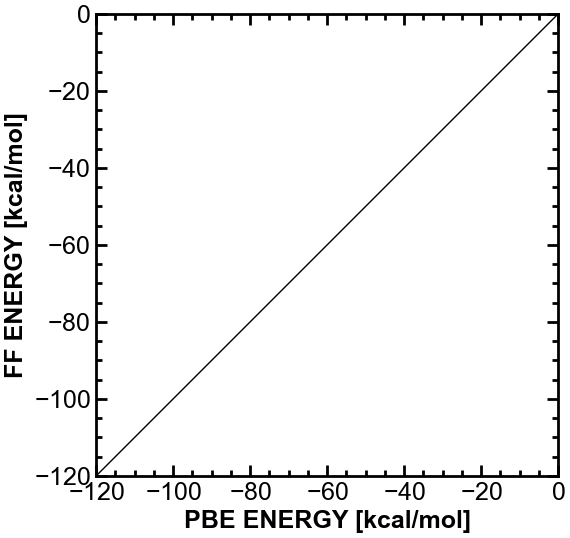

In [27]:
plt.scatter(ffeval + ljpcff_test.data["ELEC"], ljpcff_test.targets + ljpcff_test.data["ELEC"])
plt.scatter(ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"], ljpcff.targets + ljpcff.data["ELEC"] , alpha=0.1, color="gray")

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")


In [28]:
# a,b,c = ljpcff.eval_jax([0.36058475, 1.74046017, 0.1, 0.1])
# a,b,c = ljpcff.eval_jax([ 0.1, 0.1, 0.36058475, 1.74046017,])

In [29]:
np.sqrt(calc_rmse(
ffeval + ljpcff_test.data["ELEC"], ljpcff_test.targets + ljpcff_test.data["ELEC"]
))

121.457214

In [30]:
np.sqrt(calc_rmse(
ffeval + ljpcff_test.data["ELEC"], ljpcff_test.data["intE"]
))

121.45720840105996

In [31]:
np.std((ffeval+ ljpcff_test.data["ELEC"]) - (ljpcff_test.targets+ ljpcff_test.data["ELEC"]))

12.253413

In [32]:
np.sqrt(calc_rmse(
ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"], ljpcff.data["intE"]
))

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


120.76447627711494

In [33]:
np.std((ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"]) -  ljpcff.data["intE"])

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


15.247624580431339

In [52]:
from scipy.optimize import minimize

In [172]:
LJ_bound

[(0.05, 4.0), (0.05, 4.0), (1e-05, 1.0), (1e-05, 1.0)]

In [35]:
ljpcff.get_best_parm()

array([3.76532010e-01, 2.79627670e+00, 1.40089640e-03, 1.00000289e-03])

In [34]:
# minimize(ljpcff.get_loss_jax, ljpcff.get_best_parm(), method='TNC', 
#          jac=ljpcff.get_loss_grad, 
#          bounds=[(0.25,0.6), (0.25,2.0), (0.001, 0.15), (0.001, 0.15)],
#          options={"maxfun":1000},
#         )

# # method=’L-BFGS-B’


In [178]:
np.sqrt(42)

6.48074069840786

In [20]:
# OT     0.00  -0.1521  1.7682 ! ALLOW   WAT
# HT     0.00  -0.0460  0.2245 ! ALLOW WAT

In [36]:
# tip3
a,b,c = ljpcff.eval_jax([ 
        0.2245,
        1.7682, 
        0.0460, 
        0.1521, 
])
a,b,c = ljpcff_test.eval_jax(ljpcff.get_best_parm())

In [37]:
a

Array([116.51838 , 141.64348 , 125.590385, 106.05372 ,  90.44015 ,
       104.360794, 127.99717 ,  99.22554 , 127.91109 , 106.82162 ,
        98.35943 , 129.39212 , 109.111786, 124.594025, 114.16905 ,
        89.206116, 144.69887 , 123.505775,  98.22814 , 134.32855 ,
       115.352325], dtype=float32)

In [38]:
a_,b_,c_ = ljpcff.eval_jax(ljpcff.get_best_parm())

In [39]:
# ljpcff.data

(array([  1.,  25.,  92., 115., 108.,  93.,  40.,  16.,   5.,   4.]),
 array([ 66.454605,  77.914055,  89.373505, 100.832954, 112.292404,
        123.751854, 135.2113  , 146.67075 , 158.1302  , 169.58966 ,
        181.0491  ], dtype=float32),
 <BarContainer object of 10 artists>)

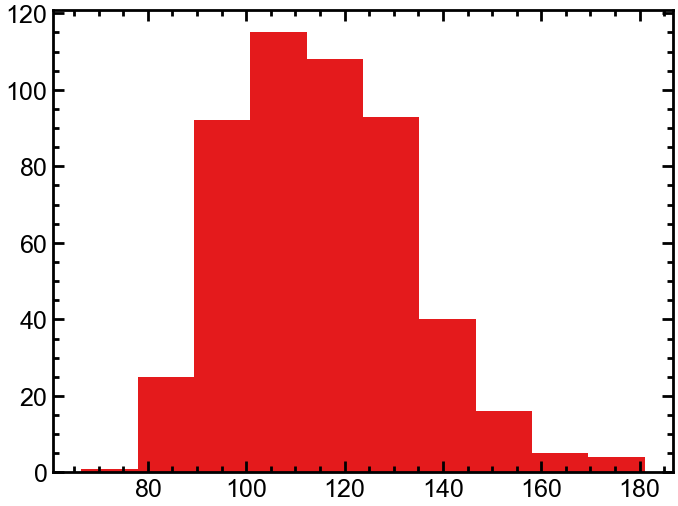

In [40]:
plt.hist(ljpcff.targets)

In [41]:
datacopy = ljpcff_test.data.copy()
datacopy["fitE"] = a
datacopy["target"] = ljpcff_test.targets
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target
KEY,,,,,,,,,,,,
test0,11.02944,-76.47372,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538,0.0,116.518379,-8.164207
test1,10.63645,-85.71770,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428,0.0,141.643478,7.982338
test10,10.09662,-89.77506,24.00860,test10,-1527.187550,20,-1527.339045,-95.064088,-958409.833043,0.0,125.590385,-5.289024
test11,9.97533,-79.93098,20.57407,test11,-1527.188313,20,-1527.344101,-97.757619,-958413.005378,0.0,106.053719,-17.826645
test12,8.69738,-67.91695,13.68166,test12,-1527.189014,20,-1527.314804,-78.933784,-958394.621611,0.0,90.440147,-11.016838
test13,10.93537,-79.04137,21.68685,test13,-1527.187075,20,-1527.320634,-83.808636,-958398.279715,0.0,104.360794,-4.767265
test14,10.62310,-71.58025,24.96655,test14,-1527.189420,20,-1527.303115,-71.344336,-958387.286722,0.0,127.997169,0.235916
test15,9.56544,-72.30831,16.59224,test15,-1527.187259,20,-1527.318020,-82.052976,-958396.639655,0.0,99.225540,-9.744667
test16,12.68634,-86.58325,25.73819,test16,-1527.184128,20,-1527.328125,-90.358079,-958402.980158,0.0,127.911087,-3.774826


In [44]:
polE = [-13.711462635646853,
-13.113443990129525,
-12.595535442732256,
-14.095311000002027,
-7.846198418099789,
-12.72244261266701,
-15.185253636471117,
-10.552430608855872,
-16.05838886235921,
-13.43546129222463,
-16.157161381764638,
-14.957260399949945,
-12.250374787929417,
-12.388647565149626,
-12.296129425331827,
-11.34820265559486,
-13.58529778172462,
-10.313607651160595,
-13.382655931830868,
-15.163951361271273,]
ciE = [-186.4160624049621 ,
-210.8178585453872 ,
-186.63950465667435 ,
-192.42826289004697 ,
-148.6699072792047 ,
-229.0402983677532 ,
-212.2632923691051 ,
-165.4285094243188 ,
-203.95356198806596 ,
-177.2197656347209 ,
-203.09565315150675,
-194.21133104742958,
-158.00573859649842,
-175.19088822767608,
-190.01157766582304,
-172.78230124266324,
-200.95302578339866,
-157.62724031739467,
-179.10331424871697,
-196.63828077925663]
datacopy = datacopy.loc[ ["test0",
"test1",
"test2",
"test3",
"test4",
"test5",
"test6",
"test7",
"test8",
"test9",
"test10",
"test11",
"test12",
"test13",
"test14",
"test15",
"test16",
"test17",
"test18",
"test19",]]
datacopy["EPOL"] = polE
datacopy["ciE"] = ciE

In [45]:
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target,EPOL,ciE
KEY,,,,,,,,,,,,,,
test0,11.02944,-76.47372,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538,0.0,116.518379,-8.164207,-13.711463,-186.416062
test1,10.63645,-85.71770,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428,0.0,141.643478,7.982338,-13.113444,-210.817859
test2,10.62982,-86.03509,21.05558,test2,-1527.187648,20,-1527.331104,-90.019409,-958404.850004,0.0,109.111786,-3.984322,-12.595535,-186.639505
test3,10.46860,-83.35005,24.12367,test3,-1527.188524,20,-1527.334367,-91.516964,-958406.897045,0.0,114.169052,-8.166908,-14.095311,-192.428263
test4,11.90133,-61.08977,13.29071,test4,-1527.183458,20,-1527.289190,-66.347298,-958378.548486,0.0,89.206116,-5.257526,-7.846198,-148.669907
test5,10.60922,-87.64687,32.48558,test5,-1527.188095,20,-1527.329776,-88.904776,-958404.016178,0.0,144.698868,-1.257904,-12.722443,-229.040298
test6,10.11763,-93.13948,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680,0.0,123.505775,-6.496277,-15.185254,-212.263292
test7,11.02849,-65.37872,16.73097,test7,-1527.185562,20,-1527.304014,-74.328571,-958387.850459,0.0,98.228142,-8.949844,-10.552431,-165.428509
test8,12.60002,-85.75712,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462,0.0,134.328552,0.295471,-16.058389,-203.953562


In [90]:
np.sqrt(calc_rmse(
    ljpcff.data.intE,
    a_ + ljpcff.data.ELECppol
))

5.517547875683837

In [91]:
np.std(ljpcff.data.intE
    - (a_ + ljpcff.data.ELECppol))

5.51556051824139

In [92]:
np.sqrt(calc_rmse(
datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
))

4.1566435495499405

In [94]:
# np.sqrt(calc_rmse(FFOBJ.data.intE, a_ + FFOBJ.data.ELEC))

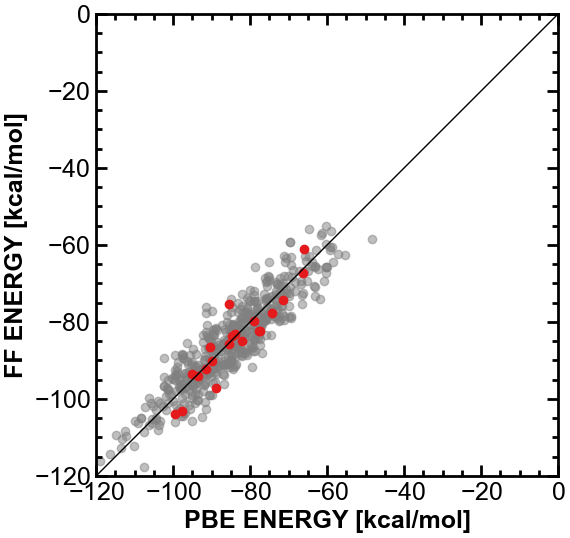

In [49]:
plt.scatter(
            ljpcff.data.intE,
            a_ + ljpcff.data.ELECcipol,  c="gray", alpha=0.5)
plt.scatter(datacopy.intE, datacopy.fitE + datacopy.ciE + datacopy.EPOL)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_pc_test.png")

In [50]:
outdf = pd.DataFrame({
    "target": ljpcff.data.intE,
    "vals":        a_ + ljpcff.data.ELECcipol
}
)

In [51]:
outdf["residuals"] = outdf["target"] - outdf["vals"]
outdf

,target,vals,residuals
KEY,,,
test0,-87.133554,-85.741219,-1.392336
test1,-76.513047,-78.965179,2.452132
test10,-79.349417,-87.548866,8.199449
test100,-77.910277,-76.509338,-1.400938
test101,-105.550755,-105.095024,-0.455731
...,...,...,...
test95,-99.981490,-94.941597,-5.039893
test96,-83.650982,-86.171135,2.520153
test97,-89.793709,-89.438843,-0.354866


In [52]:
PKL_PATH

PosixPath('/home/boittier/Documents/phd/ff_energy/pickles')

In [53]:
outdf.to_csv(PKL_PATH / "ELECpol_water_cluster_lj_elec.csv")

In [199]:
datacopy.ELEC + datacopy.EPOL

KEY
test0     -90.185183
test1     -98.831144
test2     -98.630625
test3     -97.445361
test4     -68.935968
test5    -100.369313
test6    -108.324734
test7     -75.931151
test8    -101.815509
test9     -92.246431
test10   -105.932221
test11    -94.888240
test12    -80.167325
test13    -91.430018
test14    -83.876379
test15    -83.656513
test16   -100.168548
test17    -72.367368
test18    -91.562326
test19    -95.744461
dtype: float64

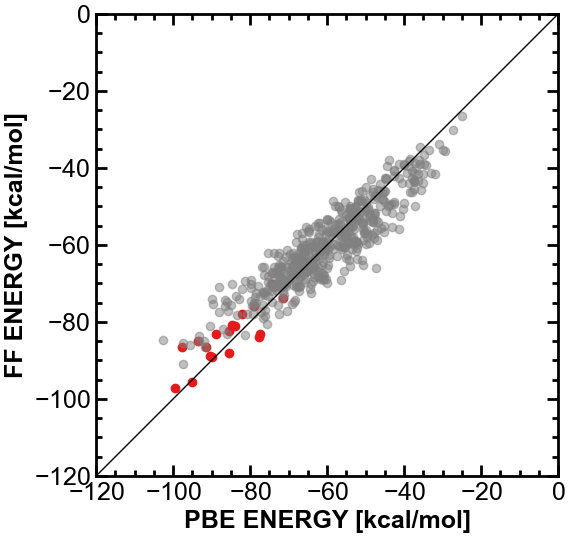

In [200]:
plt.scatter(datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
            )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELEC, c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_pc_pol_test.png")